In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
import math
import timm

import transforms.eft as Eft
from datasets.transformed_dataset import TransformedDataset
from utils import plot_confusion_matrix
from models.radio_rec_model import RadioRecNetwork
from models.resnet import create_resnet_2d
import datasets.signal_file_dataset as sfds

In [2]:
print(torch.cuda.is_available())

True


In [3]:
root = "/home/zwlin/data/radiorec/ALE2G_link11/ALE2G"
sig_file_set = sfds.SignalFileSet(root, 'wav')
sig_file_set.print_info()

data path: /home/zwlin/data/radiorec/ALE2G_link11/ALE2G
classes: ['ALE2G_chailian', 'ALE2G_hujiao', 'ALE2G_queren', 'ALE2G_yingda']
class dict: {'ALE2G_chailian': 0, 'ALE2G_hujiao': 1, 'ALE2G_queren': 2, 'ALE2G_yingda': 3}
{'ALE2G_chailian': 1, 'ALE2G_hujiao': 1, 'ALE2G_queren': 1, 'ALE2G_yingda': 1}


In [4]:
import datasets.signal_file_dataset as sfds
sig_file_conf = sfds.SignalFileConfig()
sig_file_conf.fs = 48000      # 64K Hz sample rate
sig_file_conf.seg_len = 1000   # 500ms ???
sig_file_conf.seg_shift = 1000 # 500 ms, no overlap
sig_file_conf.max_num = 2000
sig_file_conf.is_complex = True
sig_file_conf.energy_threshold = 0.0

sig_dataset = sfds.SignalDataSet(sig_file_set, sig_file_conf)
sig_dataset.print_info()

class list: ['ALE2G_chailian', 'ALE2G_hujiao', 'ALE2G_queren', 'ALE2G_yingda']
class dict: {'ALE2G_chailian': 0, 'ALE2G_hujiao': 1, 'ALE2G_queren': 2, 'ALE2G_yingda': 3}
seg count for each class: {'ALE2G_chailian': 558, 'ALE2G_hujiao': 543, 'ALE2G_queren': 541, 'ALE2G_yingda': 541}


In [5]:
sig_dataset.save('/home/zwlin/data/radiorec/ALE2G.hdf5')

In [6]:
sig_dataset = sfds.SignalDataSet()
sig_dataset.load('/home/zwlin/data/radiorec/ALE2G.hdf5')
sig_dataset.print_info()

class list: ['ALE2G_chailian', 'ALE2G_hujiao', 'ALE2G_queren', 'ALE2G_yingda']
class dict: {'ALE2G_chailian': 0, 'ALE2G_hujiao': 1, 'ALE2G_queren': 2, 'ALE2G_yingda': 3}
seg count for each class: {'ALE2G_chailian': 558, 'ALE2G_hujiao': 543, 'ALE2G_queren': 541, 'ALE2G_yingda': 541}


In [7]:
sig_dataset.data.shape

(2183, 48000, 1)

In [8]:
sig_dataset.labels.shape

(2183,)

In [9]:
class_list = sig_dataset.class_list
num_classes = len(class_list)

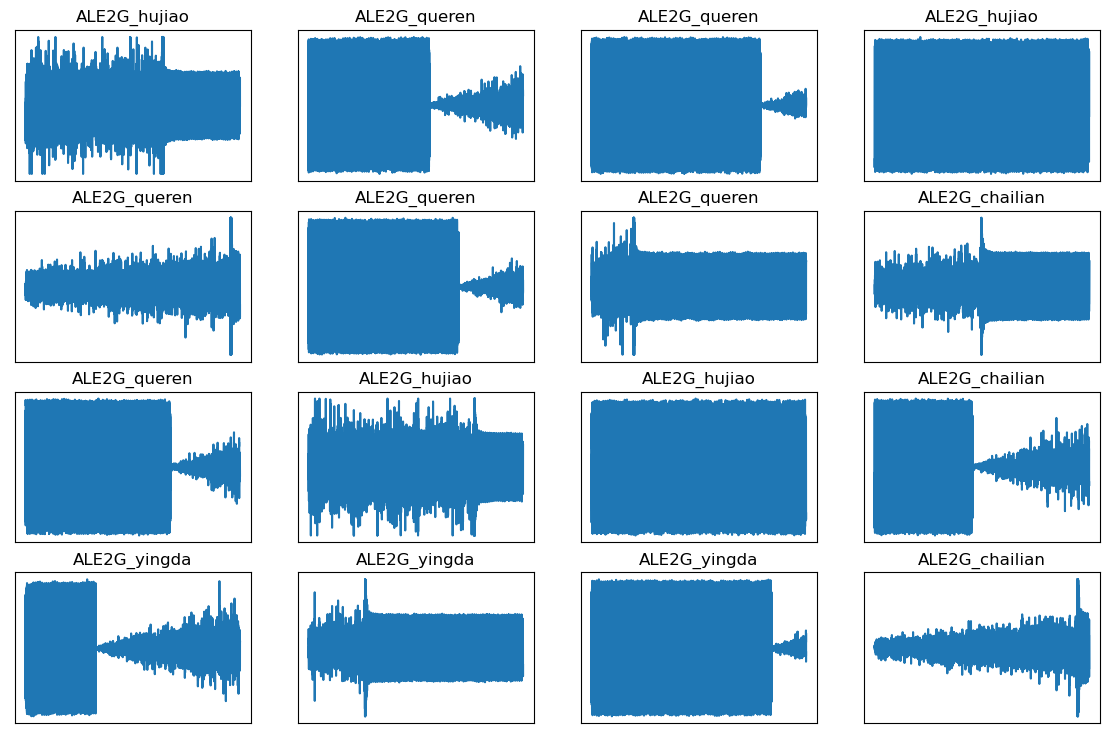

In [11]:
# Repeat but plot andom sampling of the data
from datasets.visualize import TimeSeriesVisualizer

example_dataloader = DataLoader(
    dataset=sig_dataset,
    batch_size=16,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
visualizer = TimeSeriesVisualizer(
    data_loader = example_dataloader,
    visualize_target_transform = lambda target: [class_list[int(index)] for index in target]
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

In [12]:
from transforms.transforms import Compose
from transforms.spectrogram_transform import SpectrogramConfig, Spectrogram

interleave_to_complex = Eft.InterleaveComplex()

spectrogram_config = SpectrogramConfig()
spectrogram_config.nperseg = 256
spectrogram_config.noverlap = 128
spectrogram_config.nfft = 256
spectrogram_config.window = 'hann'
spectrogram_config.return_onesided = False
spectrogram_config.mode = 'magnitude'

spectorgram_transform = Spectrogram(spectrogram_config)

ds = TransformedDataset(sig_dataset, transform = Compose([interleave_to_complex, spectorgram_transform]))

In [13]:
num_total = len(ds)
num_train = math.floor(0.8 * num_total)
num_val = math.floor(0.1 * num_total)
num_test = num_total - num_train - num_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [num_train, num_val, num_test],
                                                                         generator = torch.Generator().manual_seed(42))
idx = np.random.randint(len(train_dataset))
data, label = train_dataset[idx]
channels = data.shape[0]
print("Dataset length: {}".format(len(ds)))
print("Data shape: {}".format(data.shape))
print(f"Channels: {channels}")
print("Label Index: {}".format(label))
print("Label Class: {}".format(class_list[label]))

Dataset length: 2183
Data shape: (1, 256, 374)
Channels: 1
Label Index: 0
Label Class: ALE2G_chailian


In [14]:
# ----
# ### Format Dataset for Training
# Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=False,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=False,
)

In [15]:
model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# Training Config
learning_rate=0.002
epochs = 50

radiorec_model = RadioRecNetwork(model, learning_rate = learning_rate)

In [18]:
# ----
# ### Train the Model
# To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.
import os
checkpoint_dir=f'exp/radiorec/ALE2G-checkpoints'
if not os.path.exists(checkpoint_dir):
    print(f'mkdir: {checkpoint_dir}')
    os.makedirs(checkpoint_dir)

mkdir: exp/radiorec/ALE2G-checkpoints


In [19]:
# Setup checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [20]:
# Create and fit trainer

trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, devices=1, accelerator="gpu"
)

trainer.fit(radiorec_model, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mdl  | ResNet | 11.2 M
--------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 109: 'val_loss' reached 0.63529 (best 0.63529), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=0-val_loss=0.64.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 218: 'val_loss' reached 8.82857 (best 0.63529), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=1-val_loss=8.83.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 327: 'val_loss' reached 3.83858 (best 0.63529), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=2-val_loss=3.84.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 436: 'val_loss' reached 7.40491 (best 0.63529), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=3-val_loss=7.40.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 545: 'val_loss' reached 0.20576 (best 0.20576), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=4-val_loss=0.21.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 654: 'val_loss' reached 0.20234 (best 0.20234), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=5-val_loss=0.20.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 763: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 872: 'val_loss' reached 0.44507 (best 0.20234), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=7-val_loss=0.45.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 981: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1090: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1199: 'val_loss' reached 0.18520 (best 0.18520), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=10-val_loss=0.19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1308: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1417: 'val_loss' reached 0.20062 (best 0.18520), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=12-val_loss=0.20.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1526: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1635: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1744: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1853: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1962: 'val_loss' reached 0.14722 (best 0.14722), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=17-val_loss=0.15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 2071: 'val_loss' reached 0.14686 (best 0.14686), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=18-val_loss=0.15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2180: 'val_loss' reached 0.15079 (best 0.14686), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=19-val_loss=0.15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2289: 'val_loss' reached 0.14812 (best 0.14686), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=20-val_loss=0.15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2398: 'val_loss' reached 0.14702 (best 0.14686), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=21-val_loss=0.15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2507: 'val_loss' reached 0.14000 (best 0.14000), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=22-val_loss=0.14.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2616: 'val_loss' reached 0.14188 (best 0.14000), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=23-val_loss=0.14.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2725: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2834: 'val_loss' reached 0.14445 (best 0.14000), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=25-val_loss=0.14.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2943: 'val_loss' reached 0.14217 (best 0.14000), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=26-val_loss=0.14.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 3052: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 3161: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3270: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3379: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3488: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3597: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3706: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3815: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3924: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 4033: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 4142: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 4251: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4360: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4469: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4578: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4687: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4796: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4905: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 5014: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 5123: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 5232: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 5341: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5450: 'val_loss' was not in top 3


In [21]:
checkpoint_callback.best_model_path

'/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/ALE2G-checkpoints/epoch=22-val_loss=0.14.ckpt'

In [22]:
# After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.
checkpoint_filename = checkpoint_callback.best_model_path
# checkpoint_filename = 'exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=26-val_loss=0.13.ckpt'

# Load best checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    checkpoint_filename, map_location=lambda storage, loc: storage
)

model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
test_model = RadioRecNetwork(model, learning_rate = learning_rate)
test_model.load_state_dict(checkpoint["state_dict"])
test_model = test_model.to(device=device).eval()

In [23]:
# ### Evaluate the val set

# Infer results over validation set
num_val_examples = len(val_dataset)
y_raw_preds = np.empty((num_val_examples, num_classes))
y_preds = np.zeros((num_val_examples,))
y_true = np.zeros((num_val_examples,))

for i in tqdm(range(0, num_val_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|████████████████████████████████████████| 218/218 [00:00<00:00, 223.26it/s]


Val set classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        59
         1.0       1.00      0.88      0.94        43
         2.0       0.91      0.94      0.93        66
         3.0       0.87      0.92      0.89        50

    accuracy                           0.93       218
   macro avg       0.94      0.93      0.93       218
weighted avg       0.93      0.93      0.93       218



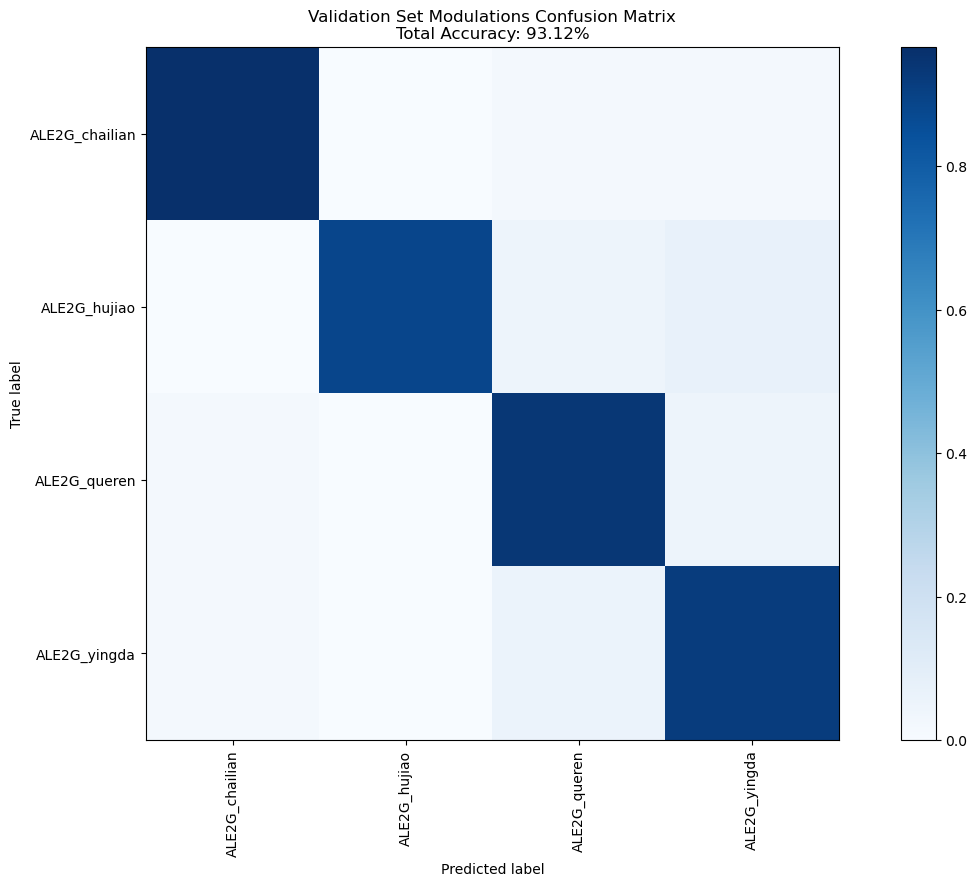

In [24]:
acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Validation Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/val_result.png")

print("Val set classification report:")
print(classification_report(y_true, y_preds))

100%|████████████████████████████████████████| 219/219 [00:00<00:00, 242.01it/s]


Test set classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94        49
         1.0       0.98      0.98      0.98        59
         2.0       0.90      0.94      0.92        47
         3.0       0.92      0.95      0.94        64

    accuracy                           0.95       219
   macro avg       0.95      0.94      0.94       219
weighted avg       0.95      0.95      0.95       219



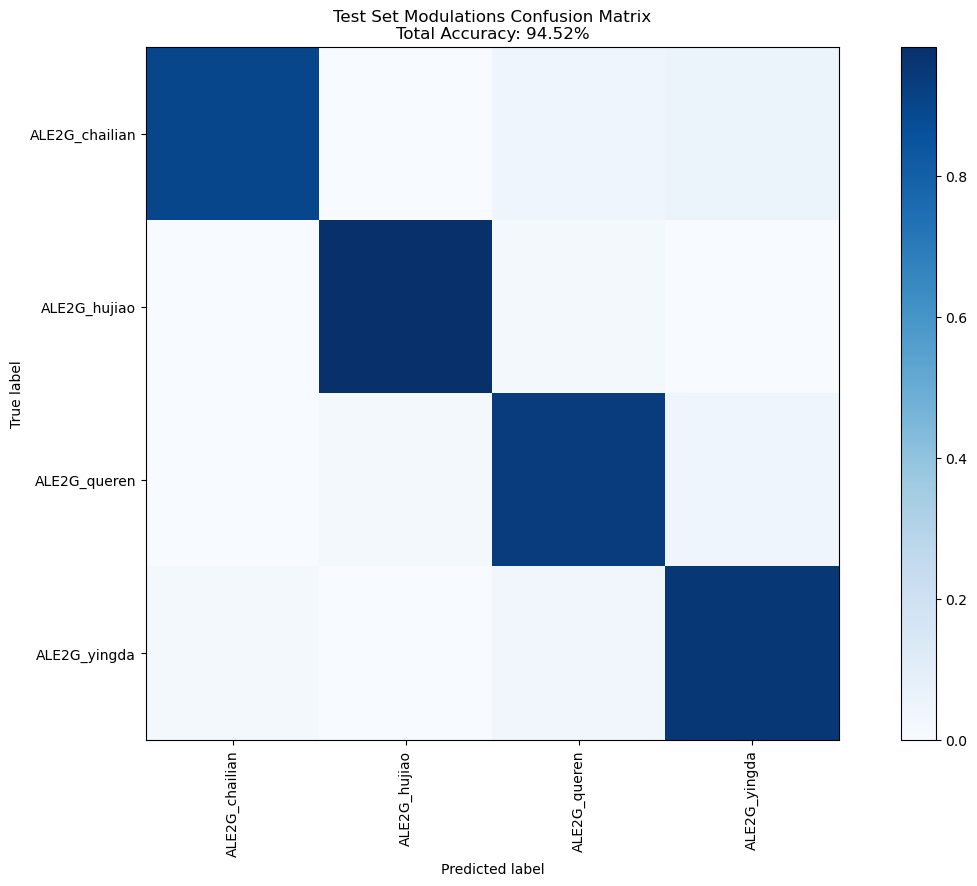

In [25]:
# ----
# ### Evaluate the test set

# Infer results over validation set
num_test_examples = len(test_dataset)
y_raw_preds = np.empty((num_test_examples, num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = test_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Test Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/test_result.png")

print("Test set classification report:")
print(classification_report(y_true, y_preds))